In [1]:
import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../src"))
# We change the working directory to the root of the project
# Run this only once
root_path = Path.cwd().parent
os.chdir(root_path)
sys.path.append(root_path / "src")

This notebook is intended to show how to use flow models with stable diffusion. We use the ```diffusers``` library to open the stable diffusion model

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

T = 1000  # number of timesteps

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Load the pretrained Stable Diffusion pipeline
pipeline = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    torch_dtype=torch.float16,

).to("cuda")


pipeline.scheduler.set_timesteps(T)

# Get access to the UNet (the noise predictor)
unet = pipeline.unet
scheduler = pipeline.scheduler
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder

# === Create your conditioning ===
prompt = ["a photo of an astronaut riding a horse"]
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")
text_input = text_input.to("cuda")
with torch.no_grad():
    text_embeddings = text_encoder(**text_input).last_hidden_state

Keyword arguments {'num_train_timesteps': 1000} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
def epsilon_prediction(t, latents):
    """
    Get the score prediction for given timesteps and latents.
    """
    latents = latents.to(dtype=torch.float16)  # Ensure latents are in float16

    # map t (0-1 float) to the scheduler timesteps (0-999)
    t = ((T - 1) * t).long().to('cuda')  # t ∈ [| 0, 999 |]

    print(f"t: {t.max()}")

    # Get the noise prediction from UNet
    with torch.no_grad():
        noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings).sample
    
    return latents - noise_pred


In [7]:
from flows.flow import Flow
from flows.path import AffinePath
from flows.schedulers import OTScheduler

scheduler = OTScheduler()

path = AffinePath(
    scheduler=scheduler
)

flow = Flow(
    path=path,
    loss_fn=lambda x: torch.mean(x**2),
    model=epsilon_prediction,
    predicts='x_0'
)

In [9]:
output = flow.sample(x_0=latents)

/home/mathis/anaconda3/lib/python3.12/site-packages/torchdiffeq/_impl/misc.py:306: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


t: 0
t: 10
t: 20
t: 30
t: 40
t: 50
t: 61
t: 71
t: 81
t: 91
t: 101
t: 112
t: 122
t: 132
t: 142
t: 152
t: 163
t: 173
t: 183
t: 193
t: 203
t: 214
t: 224
t: 234
t: 244
t: 254
t: 265
t: 275
t: 285
t: 295
t: 305
t: 316
t: 326
t: 336
t: 346
t: 356
t: 366
t: 377
t: 387
t: 397
t: 407
t: 417
t: 428
t: 438
t: 448
t: 458
t: 468
t: 479
t: 489
t: 499
t: 509
t: 519
t: 530
t: 540
t: 550
t: 560
t: 570
t: 581
t: 591
t: 601
t: 611
t: 621
t: 632
t: 642
t: 652
t: 662
t: 672
t: 682
t: 693
t: 703
t: 713
t: 723
t: 733
t: 744
t: 754
t: 764
t: 774
t: 784
t: 795
t: 805
t: 815
t: 825
t: 835
t: 846
t: 856
t: 866
t: 876
t: 886
t: 897
t: 907
t: 917
t: 927
t: 937
t: 948
t: 958
t: 968
t: 978
t: 988


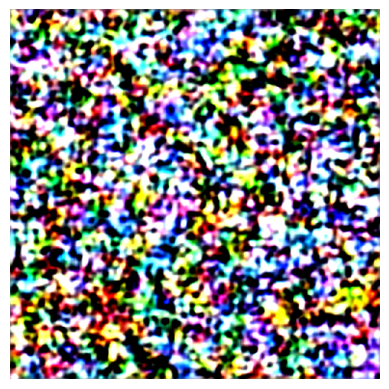

In [30]:
latents = 1 / 0.18215 * output  # Scale back from latent space
with torch.no_grad():
    image = pipeline.vae.decode(latents).sample  # shape: (bs, 3, 512, 512)

# Normalize to [0, 1] and move to CPU
image = (image.clamp(-1, 1) + 1) / 2  # [0, 1]
image = image.cpu().permute(0, 2, 3, 1).numpy()  # (bs, H, W, C)

import matplotlib.pyplot as plt

plt.imshow(image[0].astype(np.float32))
plt.axis("off")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-198.125..187.0].


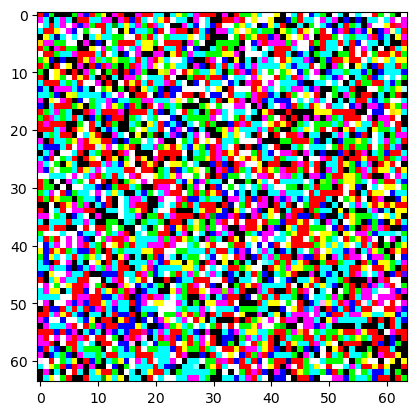

In [36]:
plt.imshow(output[0].cpu()[1:].permute(1, 2, 0).numpy().astype(np.float32))